In [1]:
from   joblib import load
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
from   sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from   source.model_evaluation import adjusted_prediction, eval_fpr_tpr, eval_sensitivity_specificity

## Settings

In [2]:
# Set feature files (contains patient info and pyradiomics features)
feature_file_test_set = 'data/test_features.csv' # RVC dataset
label_file_test_set   = 'data/test_labels.csv'

# Number of thresholds
n_thresholds = 401

# Fix seed
seed = 42
np.random.seed(seed)
random.seed(seed)

## Data

In [3]:
# Load pyradiomics features and labels
df_features_test = pd.read_csv(feature_file_test_set)
labels_test      = np.loadtxt(label_file_test_set)

In [4]:
# Inspect features
df_features_test

,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,feature 9,feature 10,...,feature 91,feature 92,feature 93,feature 94,feature 95,feature 96,feature 97,feature 98,feature 99,feature 100
0,0.408675,0.875730,0.912431,0.024102,0.881738,0.679028,0.267438,0.741496,0.472999,0.363270,...,0.197591,0.334424,0.248141,0.877542,0.730309,0.099209,0.935601,0.282520,0.671892,0.743319
1,0.082585,0.203440,0.843259,0.683400,0.321187,0.770797,0.996027,0.000808,0.717905,0.780431,...,0.017017,0.270985,0.796366,0.216108,0.784458,0.740045,0.935327,0.240973,0.974415,0.103944
2,0.260994,0.870415,0.889173,0.014100,0.779257,0.716241,0.594312,0.415500,0.489059,0.011261,...,0.249798,0.966838,0.278764,0.194563,0.786603,0.279989,0.836241,0.525359,0.246604,0.222189
3,0.519837,0.723300,0.777684,0.025297,0.513132,0.737426,0.271578,0.134972,0.942930,0.657200,...,0.904280,0.049488,0.214135,0.804656,0.050602,0.623588,0.236659,0.545989,0.237693,0.893854
4,0.307194,0.695722,0.474904,0.649843,0.677943,0.552563,0.973996,0.064768,0.658468,0.382304,...,0.060811,0.479596,0.660996,0.753045,0.046146,0.708579,0.448771,0.068917,0.263655,0.052538
5,0.166956,0.103742,0.017289,0.183186,0.593324,0.274260,0.578076,0.918260,0.164118,0.561409,...,0.571503,0.126785,0.541699,0.468253,0.821754,0.962845,0.200640,0.176783,0.893687,0.734230
6,0.596294,0.084744,0.684656,0.069647,0.666367,0.150677,0.980682,0.314438,0.258372,0.668934,...,0.832239,0.119155,0.298042,0.241155,0.702473,0.627417,0.978387,0.349496,0.117228,0.928353
7,0.627244,0.114190,0.277251,0.524234,0.115966,0.369201,0.888613,0.746878,0.081318,0.345623,...,0.287548,0.688118,0.486991,0.827329,0.630454,0.863358,0.700974,0.059226,0.450294,0.646380
8,0.655019,0.720416,0.880868,0.290105,0.620426,0.687223,0.104087,0.876473,0.791935,0.789763,...,0.738820,0.229519,0.841733,0.001299,0.222387,0.557369,0.938587,0.132908,0.841048,0.396695
9,0.972930,0.488057,0.458905,0.750386,0.868539,0.871220,0.145043,0.232145,0.302339,0.653186,...,0.928874,0.927406,0.593433,0.381362,0.584413,0.363675,0.729202,0.123135,0.922790,0.405267


In [5]:
# Inspect labels
labels_test

array([0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0.,
       1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0.])

## Feature selection

Exclude the same features from the test set which were found to be highly correlated in the training set.

In [6]:
# Get the names of features which have been dropped before training
dropped_features = np.genfromtxt('feature_selection/dropped_features.csv', delimiter=',', dtype=str)

# Drop features from the test set
df_features_test_uncorr = df_features_test.drop(columns=dropped_features[:-1])

/home/philipp/anaconda3/envs/pyrad/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: genfromtxt: Empty input file: "feature_selection/dropped_features.csv"
  


## Load random forest

Load the previously trained random forest model.

In [7]:
# Load previously trained random forest model
rf = load('trained_models/trained_random_forest_model.joblib')

## External random forest validation

We use a dedicated test dataset to get a point estimate of the performance that can be expected from the model for further unseen data. In addition, we evaluate the test data predictions for a wide range of classification thresholds in order to pick and report three different models (A, B and C) later on (see below).

In [8]:
# Prepare test dataset
X_test  = df_features_test_uncorr.to_numpy()
y_test  = labels_test

In [9]:
# Set up a wide range of classification thresholds
thresholds = np.linspace(0.0,1.0,n_thresholds)

In [10]:
bin_acc_test_set     = []
tn_test_set          = []
fp_test_set          = []
fn_test_set          = []
tp_test_set          = []
sensitivity_test_set = []
specificity_test_set = []

# Predict on test set
y_score = rf.predict_proba(X_test)

# Apply different thresholds for classification
for t in thresholds:
    
    # Adjust prediction for the current threshold
    y_pred_adj = adjusted_prediction(y_score, threshold=t, positive_label=1)

    # Prediction scores
    bin_acc_thr = accuracy_score(y_test, y_pred_adj)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_adj).ravel()
    sensitivity_thr, specificity_thr = eval_sensitivity_specificity(y_test, y_pred_adj)

    bin_acc_test_set.append(bin_acc_thr)
    tn_test_set.append(tn)
    fp_test_set.append(fp)
    fn_test_set.append(fn)
    tp_test_set.append(tp)
    sensitivity_test_set.append(sensitivity_thr)
    specificity_test_set.append(specificity_thr)
    
# ROC-curve
false_pos_rate_test_set, true_pos_rate_test_set = eval_fpr_tpr(y_test, y_score, positive_label=1)

# ROC-AUC
roc_auc_test_set = roc_auc_score(y_test, y_score[:, 1])

bin_acc_test_set     = np.asarray(bin_acc_test_set)
tn_test_set          = np.asarray(tn_test_set)
fp_test_set          = np.asarray(fp_test_set)
fn_test_set          = np.asarray(fn_test_set)
tp_test_set          = np.asarray(tp_test_set)
sensitivity_test_set = np.asarray(sensitivity_test_set)
specificity_test_set = np.asarray(specificity_test_set)

## Search classification thresholds

Sensitivity, and specificity depend on the classification threshold, a parameter which is used to turn predicted class probabilities, i.e. the output of the random forest model (here: rf.oob_decision_function_) for a given input sample, into class predictions (benign versus premalignant).

Here, we search for three different thresholds:
1. A default threshold value of 0.5 (Model A)
2. A threshold value which maximizes Youden's index (J=sensitivity+specificity1) (Model B)
3. A threshold that results in the highest possible specificity while achieving a sensitivity of at least 0.85 (Model C)

In [11]:
# Find default threshold of 0.5
ind_thr_50 = int(len(thresholds)/2.0)

# Find threshold which maximizes Youden's index J
J         = sensitivity_test_set + specificity_test_set - 1
J_max     = np.amax(J)
ind_J_test_max = np.argmax(J)
print("Maximum Youden's index J = {:0.2f} found for threshold T = {:0.4f}".format(J_max, thresholds[ind_J_test_max]))

# Find threshold which yields sensitivity of 0.85
ind_85_test = 0
while(sensitivity_test_set[ind_85_test] >= 0.85):
    ind_85_test += 1

Maximum Youden's index J = 0.13 found for threshold T = 0.5125


In [12]:
print("External validation validation:\n")
print('roc_auc:     {:.2f}'.format(roc_auc_test_set))

print("\nTest scores for threshold = {:0.3f} (Model A):\n".format(thresholds[ind_thr_50]))  
print('bin_acc:     {:0.2f}'.format(bin_acc_test_set[ind_thr_50]))
print('sensitivity: {:0.2f} ({:d}/{:d})'.format(sensitivity_test_set[ind_thr_50], tp_test_set[ind_thr_50], (tp_test_set[ind_thr_50]+fn_test_set[ind_thr_50])))
print('specifity:   {:0.2f} ({:d}/{:d})'.format(specificity_test_set[ind_thr_50], tn_test_set[ind_thr_50], (tn_test_set[ind_thr_50]+fp_test_set[ind_thr_50])))

print("\nTest scores for threshold = {:0.3f} (Model B):\n".format(thresholds[ind_J_test_max]))  
print('bin_acc:     {:0.2f}'.format(bin_acc_test_set[ind_J_test_max]))
print('sensitivity: {:0.2f} ({:d}/{:d})'.format(sensitivity_test_set[ind_J_test_max], tp_test_set[ind_J_test_max], (tp_test_set[ind_J_test_max]+fn_test_set[ind_J_test_max])))
print('specifity:   {:0.2f} ({:d}/{:d})'.format(specificity_test_set[ind_J_test_max], tn_test_set[ind_J_test_max], (tn_test_set[ind_J_test_max]+fp_test_set[ind_J_test_max])))

print("\nTest scores for threshold = {:0.3f} (Model C):\n".format(thresholds[ind_85_test]))  
print('bin_acc:     {:0.2f}'.format(bin_acc_test_set[ind_85_test]))
print('sensitivity: {:0.2f} ({:d}/{:d})'.format(sensitivity_test_set[ind_85_test], tp_test_set[ind_85_test], (tp_test_set[ind_85_test]+fn_test_set[ind_85_test])))
print('specifity:   {:0.2f} ({:d}/{:d})'.format(specificity_test_set[ind_85_test], tn_test_set[ind_85_test], (tn_test_set[ind_85_test]+fp_test_set[ind_85_test])))

External validation validation:

roc_auc:     0.51

Test scores for threshold = 0.500 (Model A):

bin_acc:     0.52
sensitivity: 0.54 (14/26)
specifity:   0.50 (12/24)

Test scores for threshold = 0.512 (Model B):

bin_acc:     0.56
sensitivity: 0.46 (12/26)
specifity:   0.67 (16/24)

Test scores for threshold = 0.460 (Model C):

bin_acc:     0.54
sensitivity: 0.85 (22/26)
specifity:   0.21 (5/24)


## ROC-Curve

Plot a ROC-curve using the false positive and true positive predictions made by the model.

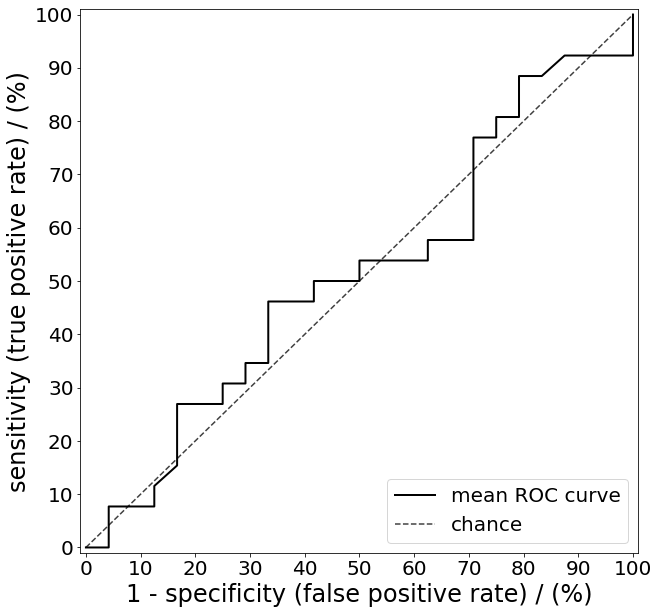

In [13]:
fpr = false_pos_rate_test_set[1]
tpr = true_pos_rate_test_set[1]

plt.figure(0, figsize=(10,10))
   
# Plot average ROC-Curve
plt.plot(fpr*100, tpr*100, color='k', lw=2, label='mean ROC curve', alpha=1.0)
    
# Plot ROC-Curve for chance
plt.plot([0, 100], [0, 100], linestyle='--', lw=1.5, color='k', label='chance', alpha=.75)

plt.xlim([-1, 101])
plt.ylim([-1, 101])
plt.xticks(np.linspace(0,100,11), fontsize=20)
plt.yticks(np.linspace(0,100,11), fontsize=20)
plt.xlabel('1 - specificity (false positive rate) / (%)', fontsize=24)
plt.ylabel('sensitivity (true positive rate) / (%)', fontsize=24)
plt.legend(loc="lower right", fontsize=20)
plt.savefig('plots/roc_curve_test_set.png')
plt.show()